In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">CIFAR-10 Image Classification with Resnet34</p>

<a id="contents_tabel"></a>    
<div style="border-radius:10px; padding: 15px; background-color: #e2c9ff; font-size:125%; text-align:left">

<h2 align="left"><font color=#8502d1>Table of Contents</font></h2>
    
* [Step 1 | Import Necessary Libraries](#import)
* [Step 2 | Define Residual Block](#block)
* [Step 3 | Build the ResNet-34 Model](#resnet34)
* [Step 4 | Loading Data and Preprocessing Data](#data)
* [Step 5 | Training the CNN Model](#train)
* [Step 6 | Visualizing the Learning Curves](#curves)
* [Step 7 | Confusion Matrix, Classification report, ROC Curve and AUC Score](#metrics)
* [Step 8 | Conclusion](#conclusion)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

<h2 align="left"><font color=#8502d1>CIFAR-10 Dataset</font></h2>

The __CIFAR-10__ dataset is a well-established benchmark in the field of machine learning, specifically designed for __image classification__. Comprising __60,000 color images__, each of __size 32x32 pixels__, the dataset is segmented into __10 distinct classes__, each representing a different object or creature. The classes encompass the following:

- Airplane
- Automobile
- Bird
- Cat
- Deer
- Dog
- Frog
- Horse
- Ship
- Truck

Each class contains an equal distribution, boasting 6,000 images. From the total image count, 50,000 are designated for training while the remaining 10,000 are set aside for testing.

<a id="import"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 1 | Import Necessary Libraries</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense, AveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

<a id="block"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 2 | Define Residual Block</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The `residual_block` function is a building block used in the ResNet architecture, which is designed to help train deep neural networks more effectively. The key idea behind this block is to make sure that information from earlier layers can easily pass through to later layers, which helps the network learn better.

Here's how it works: the function first takes an input (`x`) and saves it as a `shortcut`. It then applies two sets of operations to the input: a convolution (which helps the network learn patterns), followed by Batch Normalization (which helps stabilize and speed up training), and finally, a ReLU activation (which introduces non-linearity to the model, allowing it to learn more complex patterns). After these operations, if the processed output doesn't match the size of the original input, the `shortcut` is adjusted to match. 

The crucial part of this block is that it adds the original input (`shortcut`) back to the processed output. This addition allows the network to "skip" certain layers if needed, making it easier to train even very deep networks. Finally, another ReLU activation is applied to the combined result, and this is returned as the output of the block. By using this design, the ResNet architecture can learn more effectively, especially as the network gets deeper.

In [3]:
# Define a residual block
def residual_block(x, filters, kernel_size=3, stride=1, with_shortcut=True):
    shortcut = x
    
    # First convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    # Second convolution
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    
    if with_shortcut:
        # Adjust shortcut to match dimensions
        if x.shape[-1] != shortcut.shape[-1] or stride != 1:
            shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(shortcut)
            shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x, shortcut])
    x = ReLU()(x)
    
    return x

<a id="resnet34"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 3 | Build the ResNet-34 Model</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The `build_resnet34` function constructs the ResNet-34 model, a popular deep learning architecture known for its effectiveness in image classification tasks. Here's how it works:

1. **Input Layer**: An input layer that takes images with the shape specified by `input_shape`.

2. **Initial Convolution Layer**: The first layer applies a large convolution (7x7 filter size) to the input, which helps to capture broad features in the images. This is followed by batch normalization to stabilize training and a ReLU activation to introduce non-linearity. Then, an average pooling layer reduces the spatial dimensions, making the subsequent computations more efficient.

3. **Residual Blocks**: The core of the model consists of several residual blocks, which are repeated layers that help the model learn better by allowing the network to "skip" layers if needed. These blocks are designed to handle different feature complexities by progressively increasing the number of filters (64, 128, 256, and 512) and occasionally downsampling the feature maps using strides of 2.

4. **Global Average Pooling and Output Layer**: After the residual blocks, the model applies global average pooling, which reduces each feature map to a single value, summarizing the presence of features across the entire image. Finally, a dense (fully connected) layer with `num_classes` neurons and a softmax activation function outputs the class probabilities, making it suitable for multi-class classification tasks.

In [4]:
# Build the ResNet-34 model
def build_resnet34(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = AveragePooling2D((3, 3), strides=2, padding='same')(x)
    
    # Residual Blocks
    x = residual_block(x, 64)
    x = residual_block(x, 64)
    x = residual_block(x, 128, stride=2)
    x = residual_block(x, 128)
    x = residual_block(x, 256, stride=2)
    x = residual_block(x, 256)
    x = residual_block(x, 512, stride=2)
    x = residual_block(x, 512)
    
    # Global Average Pooling and Fully Connected Layer
    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, x)
    return model

<a id="data"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 4 | Loading Data and Preprocessing Data</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The CIFAR-10 dataset is loaded using the `cifar10.load_data()` function, which returns the training and test datasets. This dataset consists of 60,000 32x32 color images across 10 different classes, with 50,000 images for training and 10,000 for testing. It's a standard benchmark dataset for evaluating machine learning models.

In [5]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

Normalizing the images by dividing the pixel values by 255 scales the pixel values from the range 0-255 to 0-1. This helps the model train more efficiently by ensuring that the input values are small and standardized, which leads to faster convergence and improved performance.

In [6]:
# Normalize the images
x_train, x_test = x_train / 255.0, x_test / 255.0

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The labels in the CIFAR-10 dataset are originally integers representing different classes. Converting them to one-hot encoding transforms each label into a binary vector, where the position corresponding to the label is marked as 1, and the rest are 0. This format is useful for training neural networks in multi-class classification problems, as it allows the model to predict probabilities for each class.

In [7]:
# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

Data augmentation is applied to increase the diversity of the training dataset by applying random transformations like rotation, shifting, and flipping. This helps the model generalize better by preventing overfitting, as it sees a wider variety of image variations during training. The `datagen.fit(x_train)` line prepares the data generator to apply these transformations to the training images.

In [8]:
# Create data generators for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(x_train)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

- Adam, which adjusts the learning rate dynamically based on the gradients, helping the model converge faster and more reliably. 

- The loss function is categorical crossentropy, which measures how well the predicted class probabilities match the true labels. 

In [9]:
# Build and compile the model
model = build_resnet34(input_shape=(32, 32, 3), num_classes=10)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
# Print model summary
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 16, 16,    │      9,472 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 16, 16,    │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 8, 8, 64)  │          0 │ re_lu[0][0]       │
│ (AveragePooling2D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 8, 8, 64)  │          0 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 8, 8, 64)  │     36,928 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 8, 8, 64)  │        256 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 8, 8, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 8, 8, 64)  │          0 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 11,196,042 (42.71 MB)

 Trainable params: 11,186,442 (42.67 MB)

 Non-trainable params: 9,600 (37.50 KB)

<a id="train"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 5 | Train the Model</p>

⬆️ [Tabel of Contents](#contents_tabel)

In [11]:
# Train the model
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=64),
    epochs=100,
    validation_data=(x_test, y_test),
    verbose=1
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1725461346.987939     103 service.cc:145] XLA service 0x7f5fb4001a50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725461346.987996     103 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1725461346.988003     103 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  5/782 ━━━━━━━━━━━━━━━━━━━━ 29s 39ms/step - accuracy: 0.1095 - loss: 3.4805 

I0000 00:00:1725461355.798349     103 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 56ms/step - accuracy: 0.3504 - loss: 1.8719 - val_accuracy: 0.3079 - val_loss: 2.0107
Epoch 2/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 64s 44ms/step - accuracy: 0.4930 - loss: 1.4230 - val_accuracy: 0.3435 - val_loss: 2.0416
Epoch 3/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.5543 - loss: 1.2655 - val_accuracy: 0.3587 - val_loss: 2.4460
Epoch 4/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.5935 - loss: 1.1543 - val_accuracy: 0.5274 - val_loss: 1.3828
Epoch 5/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6218 - loss: 1.0748 - val_accuracy: 0.5495 - val_loss: 1.3218
Epoch 6/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6478 - loss: 0.9999 - val_accuracy: 0.6423 - val_loss: 1.0332
Epoch 7/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 43ms/step - accuracy: 0.6763 - loss: 0.9302 - val_accuracy: 0.4982 - val_loss: 1.5237
Epoch 8/100
782/782 ━━━━━━━━━━━━━━━━━━━━ 34s 44ms/step - accuracy: 0.6872 - loss: 0.8947 - val_

<a id="curves"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 6 | Visualizing the Learning Curves</p>

⬆️ [Tabel of Contents](#contents_tabel)

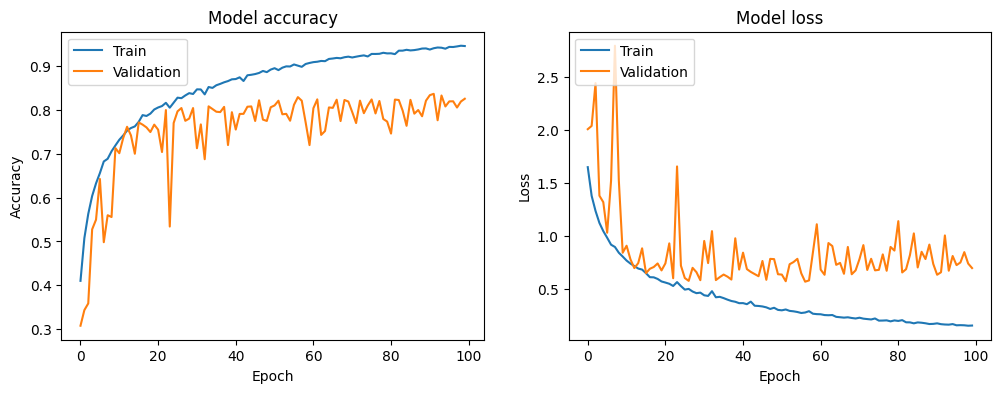

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

<a id="metrics"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 7 | Confusion Matrix, Classification report, ROC Curve and AUC Score</p>

⬆️ [Tabel of Contents](#contents_tabel)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step


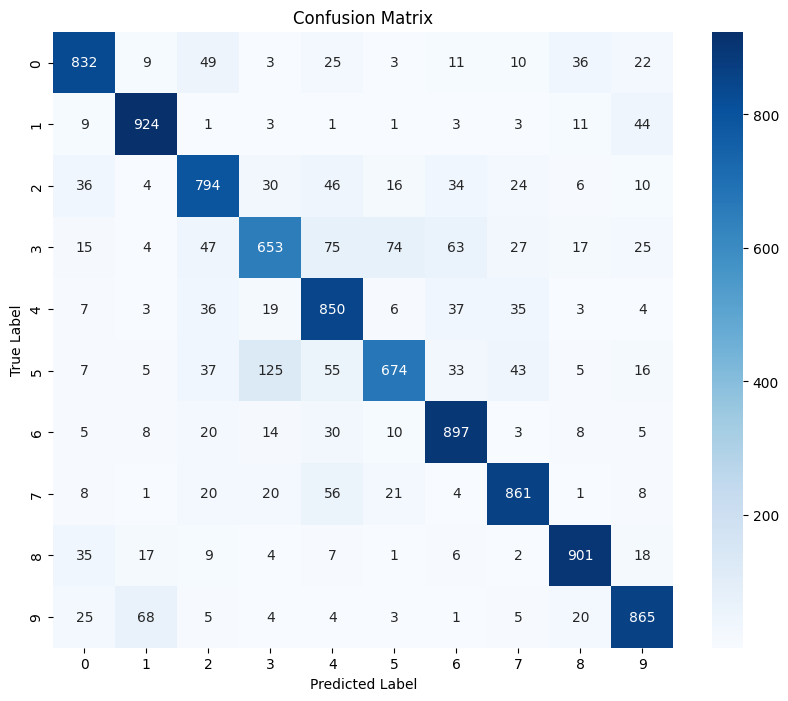

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.89      0.92      0.90      1000
           2       0.78      0.79      0.79      1000
           3       0.75      0.65      0.70      1000
           4       0.74      0.85      0.79      1000
           5       0.83      0.67      0.75      1000
           6       0.82      0.90      0.86      1000
           7       0.85      0.86      0.86      1000
           8       0.89      0.90      0.90      1000
           9       0.85      0.86      0.86      1000

    accuracy                           0.83     10000
   macro avg       0.83      0.83      0.82     10000
weighted avg       0.83      0.83      0.82     10000



In [13]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Predict the classes
y_pred = model.predict(x_test)
y_pred_classes = y_pred.argmax(axis=1)
y_true = y_test.argmax(axis=1)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_true, y_pred_classes))

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The classification report reveals balanced performance across the classes, with an overall accuracy of 83%. The precision, recall, and f1-score metrics are generally strong, with the highest f1-scores observed for classes 1 and 8, indicating good performance in these categories. However, class 5 shows lower scores, particularly in recall and f1-score, suggesting that the model may struggle more with this class.

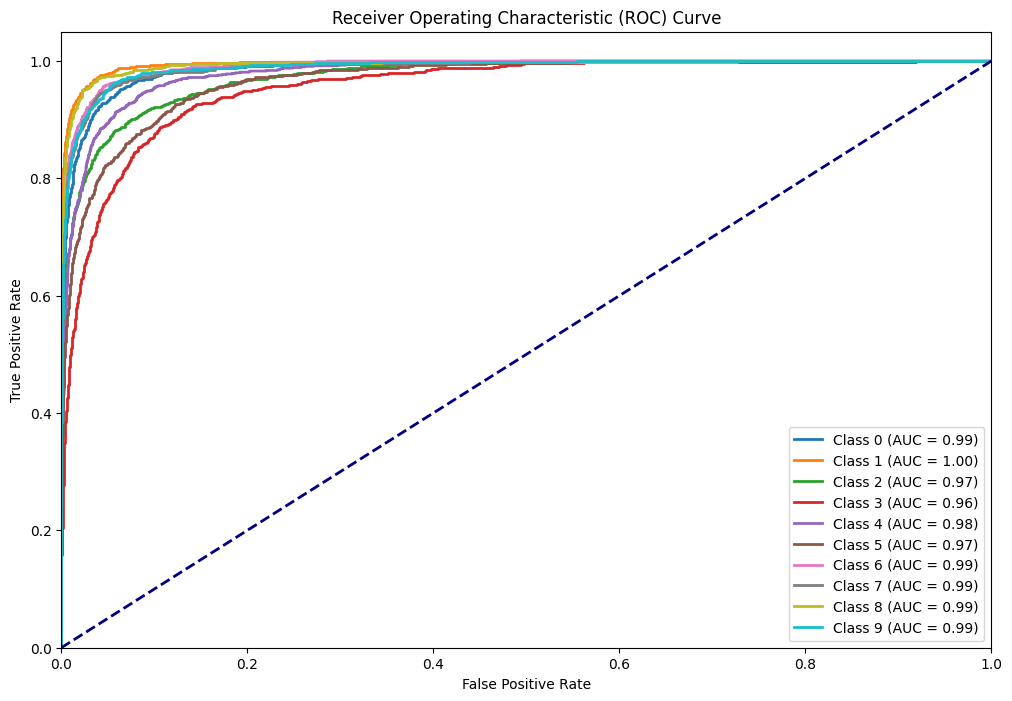

In [14]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(12, 8))
for i in range(10):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

The ROC curves and AUC scores demonstrate excellent performance across all classes. With AUC values ranging from 0.96 to 1.00, the model shows high discriminative ability for each class. Specifically, classes 1, 6, 7, 8, and 9 achieve near-perfect AUC scores of 0.99, indicating exceptional classification performance. These results suggest that the model effectively distinguishes between classes and is well-suited for the task at hand.

<a id="conclusion"></a>
## <p style="background-color:#8502d1; font-family:calibri; color:white; font-size:150%; text-align:center; border-radius:15px 50px;">Step 8 | Conclusion</p>

⬆️ [Tabel of Contents](#contents_tabel)

<div style="border-radius:12px; padding: 20px; background-color: #e2c9ff; font-size:125%; text-align:left">

In our comparison of ResNet34 and a custom CNN on the CIFAR-10 dataset, the improved custom CNN achieved an accuracy of 91.94%, surpassing the 83% accuracy of the ResNet34 model. Despite ResNet34's well-regarded architecture for deep learning tasks, this performance gap may arise due to several factors:

1. **Architectural Differences**: The custom CNN might have been specifically designed with features more suited to the CIFAR-10 dataset, such as tailored convolutional layers or optimized hyperparameters.
   
2. **Training Strategy**: Differences in training procedures, such as learning rates, batch sizes, or data augmentation techniques, could impact performance.

3. **Overfitting vs. Generalization**: ResNet34, being a deeper network, may have a higher risk of overfitting, especially if not properly regularized or if the dataset size and diversity are not sufficient.

Overall, while ResNet34 is a robust architecture, its performance on CIFAR-10 in this instance was outperformed by a custom model tailored to the specific dataset and task.